In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import mne
import mne
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)
data_dir = 'data_meg'
subj = "R2488"
dataqual = 'prepro' #or loc/exp
exp = 'loc' #or exp
dtype = "raw"
label_dir = 'data_log'
save_dir = 'data_meg'
bad_channels_dict = {
    "R2490": ['MEG 014', 'MEG 004', 'MEG 079', 'MEG 072', 'MEG 070', 'MEG 080', 'MEG 074', 'MEG 067', 'MEG 082', 'MEG 105', 'MEG 115', 'MEG 141', 'MEG 153'],
    "R2488": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 146', 'MEG 147', 'MEG 007', 'MEG 141'],
    "R2487": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 147', 'MEG 146', 'MEG 004'],
    "R2280": ['MEG 024', 'MEG 039', 'MEG 079', 'MEG 077', 'MEG 141', 'MEG 073', 'MEG 075', 'MEG 076', 'MEG 064', 'MEG 063', 'MEG 060', 'MEG 059', 'MEG 058']
}
bad_channels = bad_channels_dict.get(subj, [])
# raw_empty_room = mne.io.read_raw_fif(f'{data_dir}/{subj}/emptyroom/{subj}_emptyroom-{dtype}.fif', preload=True)
# raw_empty_room.info['bads'].extend(bad_channels)


In [2]:
# raw = mne.io.read_raw_fif('data_meg/R2490/prepro/R2490_exp.fif', preload='temp_raw.fif')
raw = mne.io.read_raw_fif(f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif', preload=True)
raw.info['bads'].extend(bad_channels)
sfreq = raw.info['sfreq']
raw.filter(1, 20, method='iir')
downsample = 10
raw.resample(sfreq / downsample)
# raw.drop_channels(bad_channels)

Opening raw data file data_meg/R2488/prepro/R2488_loc.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_77608/182375445.py:2: RuntimeWarning: This filename (data_meg/R2488/prepro/R2488_loc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif', preload=True)


    Range : 0 ... 835999 =      0.000 ...   835.999 secs
Ready.
Reading 0 ... 835999  =      0.000 ...   835.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

300 events found on stim channel STI 014
Event IDs: [160 164 165]
245 events found on stim channel STI 014
Event IDs: [160 164 165]


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_77608/182375445.py:7: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(sfreq / downsample)


<Raw | R2488_loc.fif, 193 x 83600 (836.0 s), ~124.6 MB, data loaded>

In [3]:
# raw_empty_room.info["bads"] = [bb for bb in raw.info["bads"] if "MEG" not in bb]
# raw_empty_room.add_proj(
#     [pp.copy() for pp in raw.info["projs"] if "MEG" not in pp["desc"]]
# )

# noise_cov = mne.compute_raw_covariance(raw_empty_room, tmin=0, tmax=None)

In [4]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 160,
    'move': 161,
    'reveal_red': 162,
    'reveal_white': 163,
    'done': 164,
    'choice': 165,
    'timeout': 166
}

start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']] 
timeout_events = events[events[:, 2] == event_id['timeout']]
choice_events = events[events[:, 2] == event_id['choice']]
sfreq = raw.info['sfreq']

245 events found on stim channel STI 014
Event IDs: [160 164 165]


In [5]:
if subj == "R2488" :
    done_events = done_events[1:]
# Initialize a list to store filtered done events
filtered_done_events = [done_events[0]]  # Start with the first event

# Check for at least 3 seconds between each done event
for i in range(1, len(done_events)):
    time_diff = (done_events[i, 0] - done_events[i-1, 0]) / sfreq
    if time_diff < 2:
        print(f"Warning: Less than 3 seconds between done events at indices {i-1} and {i}")
    
    else:
        filtered_done_events.append(done_events[i])
done_events = filtered_done_events
done_events = done_events[-120:]
# Use filtered_done_events for further processing
print(f"Filtered done events count: {len(filtered_done_events)}")



Filtered done events count: 120


In [6]:
choice_events = events[events[:, 2] == event_id['choice']]
start_events = np.array([[done_event[0] - int(3 * sfreq), 0, event_id['start']] for done_event in done_events])
# start_events = events[events[:, 2] == event_id['start']]
# start_events = start_events[-120:]
sfreq = raw.info['sfreq']  # Sampling frequency


# Initialize a list to store trial information
trial_info = []
start_idx = 0

# Iterate through each reconstructed start event to create trial information
for start_event, done_event in zip(start_events, done_events):
    start_sample = start_event[0]
    done_sample = done_event[0]
    # done_sample = start_sample + int(3.4 * sfreq)
    # Calculate tmin and tmax for the epoch
    tmin = -0.2  # 0.2 s before 'start'
    tmax = (done_sample - start_sample) / sfreq  # Duration from 'start' to 'done'
    # Find choice events within the trial
    choice_event = choice_events[(choice_events[:, 0] > start_sample) & 
                                 (choice_events[:, 0] < done_sample + int(0.5*sfreq))]
    choice_time = choice_event[-1, 0] if len(choice_event) > 0 else None
    
    # Store trial information
    trial_info.append({
        'event_sample': done_sample,
        'trial_index': start_idx,
        'duration': tmax,
        'tmin': tmin,
        'tmax': tmax,
        'done': len(done_events) > 0,
        'done_times': done_sample / sfreq,
        'start_times': start_sample / sfreq,
        'choice_event': len(choice_event) > 0,
        'choice_time': choice_time / sfreq if len(choice_event) > 0 else None
    })
    start_idx += 1

In [7]:
# Use the trial information to create epochs
picks = mne.pick_types(raw.info, meg=True, exclude='bads')
data_list = []
for info in trial_info:
    start_sample = info['start_times'] * sfreq
    done_sample = info['done_times'] * sfreq
    tmin = -0.2 # 0.2 s before 'start'
    tmax = 1.5  # Duration from 'start' to 'done'
    print(start_sample, done_sample)
    event = [int(start_sample), 0, event_id['start']]
    epochs = mne.Epochs(
        raw, [event], event_id={'start': event_id['start']},
        tmin=tmin, tmax=tmax, preload=True, picks=picks,
        reject_by_annotation=False, reject=None, verbose=True
    )
    data_list.append(epochs.get_data())

21183.0 21483.0
Not setting metadata


1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 171 original time points ...
0 bad epochs dropped
21677.0 21977.0
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 171 original time points ...
0 bad epochs dropped
22171.0 22471.0
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 171 original time points ...
0 bad epochs dropped
22666.0 22966.0
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and

In [8]:
noise_cov_reg = mne.compute_covariance(epochs, tmax=0.0, method="pca", rank="full")

Reducing data rank from 149 -> 149


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_77608/2898505299.py:1: RuntimeWarning: Too few samples (required : 750 got : 21), covariance estimate may be unreliable
  noise_cov_reg = mne.compute_covariance(epochs, tmax=0.0, method="pca", rank="full")


Estimating covariance using PCA
... rank: 5 - loglik: -1190.027
... rank: 10 - loglik: -615855.715
... infinite values encountered. stopping estimation
... best model at rank = 5
Done.
Number of samples used : 21
[done]


In [9]:
# new_events = np.array([[info['event_sample'], 0, event_id['done']] for info in trial_info])
# choice_events = np.array([[info['event_sample'], 0, event_id['choice']] for info in trial_info])

# # Initialize lists to store individual epochs data and trial information
# data_list = []

# for idx, event in enumerate(new_events):
#     choice_time = info['choice_time']  # Retrieve choice_time for the current trial
#     if choice_time is not None:
#         start_sample = int(choice_time * sfreq)  # Convert choice_time to sample index
#         tmin = -0.5  # 0.5 s before 'choice'
#         tmax = 0.5  # 0.5 s after 'choice'
#     else:
#         start_sample = int(info['done_times'] * sfreq)  # Use done time if choice_time is not available
#         tmin = -3.5  # 1 s before 'done'
#         tmax = 0.1 # At 'done'
    
#     event_id_code = event_id['choice'] if choice_time is not None else event_id['done']
#     event = [start_sample, 0, event_id_code]
#     picks = mne.pick_types(raw.info, meg=True, exclude='bads')

#     epochs = mne.Epochs(
#         raw, [event], event_id={f'event_{event_id_code}': event_id_code},
#         tmin=tmin, tmax=tmax, preload=True, picks=picks,
#         reject_by_annotation=False, reject=None, verbose=True
#     )
#     data_list.append(epochs.get_data())

In [10]:
print(len(data_list))

120


In [11]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut
from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer, GeneralizingEstimator
from scipy.ndimage import gaussian_filter1d
import joblib  # For saving the model
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


In [12]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipe = Pipeline([
    ("scale", StandardScaler()),              # Scale the features
    ("reduce_dims", PCA()),                   # Apply PCA
    ("ridge", Ridge())                        # Ridge Regression
])

# Define the grid of hyperparameters
param_grid = {
    "reduce_dims__n_components": [0.5, 0.75, 0.95],  # Retain 50%, 75%, or 95% variance
    "ridge__alpha": np.logspace(-5, 5, 10),          # Regularization strength
    "ridge__fit_intercept": [True, False],           # Fit intercept or not
}

# Set up GridSearchCV
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10)


In [13]:
# Assuming X is your feature matrix with shape (n_epochs, n_channels, n_times)
X = np.array([md.data for md in data_list])  # Ensure this is 3D
X = X.squeeze(axis=1)  # This might reduce dimensions, ensure it's still 3D

# Load the CSV file
locolizer = pd.read_csv(f'{label_dir}/{subj}/loc_data.csv')

# Extract valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info}

# Extract labels and group information
rule_label = locolizer.loc[locolizer['trial_index'].isin(valid_trial_indices), 'rule'].values
group_start = locolizer.loc[locolizer['trial_index'].isin(valid_trial_indices), 'num_start'].values
y = np.array(group_start)

In [14]:
# Assuming X is your feature matrix with shape (n_epochs, n_channels, n_times)
X = np.array([md.data for md in data_list])  # Ensure this is 3D
X = X.squeeze(axis=1)  # This might reduce dimensions, ensure it's still 3D

# Load the CSV file
locolizer = pd.read_csv(f'{label_dir}/{subj}/loc_data.csv')

# Extract valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info}

# Extract labels and group information
rule_label = locolizer.loc[locolizer['trial_index'].isin(valid_trial_indices), 'rule'].values
group_start = locolizer.loc[locolizer['trial_index'].isin(valid_trial_indices), 'num_start'].values
y = np.array(group_start)

# Identify unique group_start labels
unique_groups = np.unique(group_start)
n_classes = len(unique_groups)


def flatten_data(X):
    n_samples, n_channels, n_timepoints = X.shape
    print(n_samples, n_channels, n_timepoints)
    return X.reshape(n_samples, n_channels * n_timepoints)

def smooth_scores(scores, sigma=2):
    return gaussian_filter1d(scores, sigma=sigma)

def plot_time_decoding(scores_mean,title, subj):
    n_time_points = scores_mean.shape[0]

    plt.plot(np.arange(n_time_points), scores_mean)
    plt.ylim(0, 0.6)
    plt.xlim(0, 100)
    plt.axhline(1/n_classes, color='k', linestyle='--', label='chance')
    plt.axvline(20, color='k', linestyle='--')
    plt.xlabel('Time Points')
    plt.ylabel('Accuracy')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Define the two groups based on a new threshold value
threshold = 15
group_data = {'greater_than_15': [], 'smaller_than_15': []}
group_labels = {'greater_than_15': [], 'smaller_than_15': []}

# Populate group_data and group_labels based on the new threshold
for idx, info in enumerate(trial_info):
    trial_index = info['trial_index']
    if trial_index in valid_trial_indices:
        group_value = group_start[idx]  # Assuming group_start is the feature to be compared
        if group_value > threshold:
            group = 'greater_than_15'
        else:
            group = 'smaller_than_15'
        
        # Ensure the group is correctly assigned
        if group in group_data:
            group_data[group].append(X[idx])  # Ensure X[idx] is 3D
            group_labels[group].append(rule_label[idx])
        else:
            print(f"Unexpected group value: {group_value}")



# # Train and evaluate the model for each group
# for group in ['greater_than_15', 'smaller_than_15']:
#     X_group = np.array(group_data[group])
#     y_group = np.array(group_labels[group])
    
#     # Debugging: Check the shape of X_group
#     print(f"Group: {group}, X_group shape: {X_group.shape}")
    
#     cv = LeaveOneOut()
    
#     # Train the decoder
#     clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
#     time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')

#     scores = cross_val_multiscore(time_decoding, X_group, y_group, cv=cv, n_jobs=5)
#     scores_mean = np.mean(scores, axis=0)
#     plot_time_decoding(scores_mean, f'Time Decoding {group}', subj)

In [15]:
locolizer 

,Unnamed: 0,trial_index,t,num_choice,final_choice,choice_time,rule,num_start,num_red,correct
0,0,0,0,1,1,1.809277,1,25,8,1
1,1,1,0,1,3,1.098260,3,25,3,1
2,2,2,0,1,3,1.073618,2,25,2,0
3,3,3,0,1,1,0.772736,1,25,10,1
4,4,4,0,1,1,1.673271,1,25,3,1
...,...,...,...,...,...,...,...,...,...,...
115,115,115,0,0,0,3.000000,2,4,2,0
116,116,116,0,0,0,3.000000,2,4,1,0
117,117,117,0,0,0,3.000000,2,4,2,0
118,118,118,0,1,2,1.210122,2,4,4,1


In [16]:
from sklearn.model_selection import StratifiedKFold

# Extract group_start as y_label
y_label = locolizer.loc[locolizer['trial_index'].isin(valid_trial_indices), 'rule'].values

# Filter y_label to only include values 25 and 4
valid_indices = np.isin(y_label, [1,2])
y_label_filtered = y_label[valid_indices]

# Ensure X is 3D and y_label is aligned with X
X = np.array([md.data for md in data_list])  # Ensure this is 3D
X = X.squeeze(axis=1)  # This might reduce dimensions, ensure it's still 3D

# Filter X to correspond to the filtered y_label
X_filtered = X[valid_indices]

# Reshape X_filtered to 2D: (n_samples, n_features)
n_samples, n_channels, n_timepoints = X_filtered.shape
X_reshaped = X_filtered.reshape(n_samples, n_channels * n_timepoints)

print(f"X shape: {X_filtered.shape}, y_label shape: {y_label_filtered.shape}")
# Train and evaluate the model using group_start as y_label
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1000))
# time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='roc_auc')

# scores = cross_val_multiscore(time_decoding, X_filtered, y_label_filtered, cv=cv, n_jobs=5)
# scores_mean = np.mean(scores, axis=0)
# plot_time_decoding(scores_mean, 'Time Decoding using group_start', subj)


X shape: (80, 149, 171), y_label shape: (80,)


/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Fitting SlidingEstimator : 171/171 [00:02<00:00,   65.42it/s]


No projector specified for this dataset. Please consider the method self.add_proj.


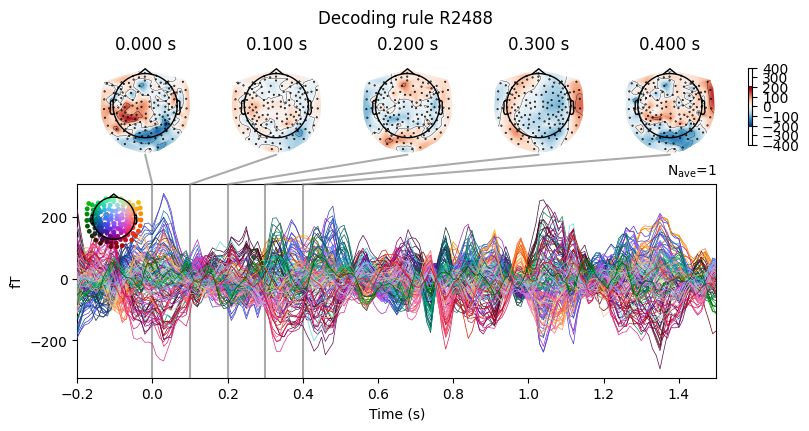

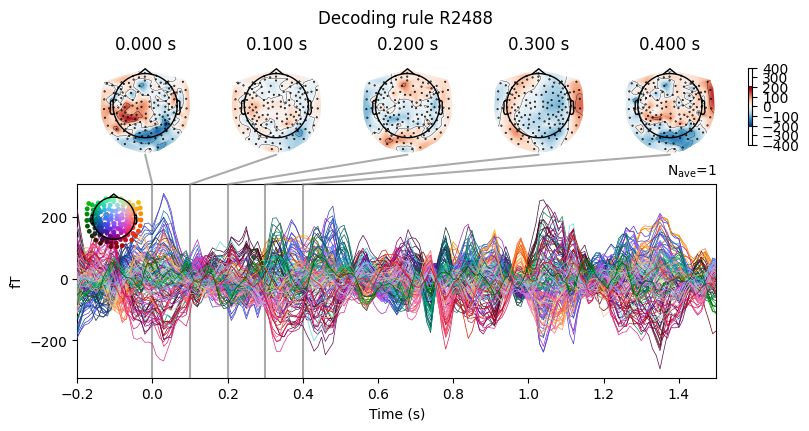

In [17]:
clf = make_pipeline(
    StandardScaler(), LinearModel(LogisticRegression(solver="lbfgs"))
)
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="accuracy", verbose=True)
time_decod.fit(X_filtered, y_label_filtered)

coef = get_coef(time_decod, "patterns_", inverse_transform=True)
coef_2d = coef.reshape(coef.shape[0], -1)
evoked_time_gen = mne.EvokedArray(coef_2d, epochs.info, tmin=epochs.times[0])

joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))
evoked_time_gen.plot_joint(
    times=np.arange(0.0, 0.500, 0.100), title=f"Decoding rule {subj}", **joint_kwargs
)

In [18]:
# clf = make_pipeline(
#     StandardScaler(),                      # Standardize the features
#     PCA(n_components=0.95),                # Retain 95% of explained variance
#     LinearModel(LogisticRegressionCV(solver="lbfgs", max_iter=1000))  # Logistic regression
# )

# time_decod = SlidingEstimator(clf, n_jobs=None, scoring="accuracy", verbose=True)
# time_decod.fit(X, y)
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_multiscore(time_decod, X_filtered, y_label_filtered, cv=cv, n_jobs=None)

# # Mean scores across cross-validation splits
# scores = np.mean(scores, axis=0)
# mean_accuracy = scores.mean()
# print(mean_accuracy)


In [19]:
def plot_average_time_decoding_with_variance_and_binning(scores, title, subj, n_classes, bin_size=10):
    # Read the data from the specified files
    bin_size = 10
    # Reshape and average every `bin_size` time points
    n_time_points = scores.shape[0]
    n_bins = n_time_points // bin_size
    binned_mean = scores[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
    binned_std = scores[:n_bins * bin_size].reshape(n_bins, bin_size).std(axis=1)
    
    # Plotting
    time_points = np.arange(n_bins) * bin_size
    
    plt.plot(time_points, binned_mean, label='Mean Accuracy')
    plt.fill_between(time_points, binned_mean - binned_std, binned_mean + binned_std, alpha=0.2, label='Variance')
    plt.ylim(0, 1)
    plt.axhline(1/2, color='k', linestyle='--', label='Chance')
    plt.axvline(20, color='k', linestyle='--')
    plt.xlabel('Time Points (binned)')
    plt.ylabel('Accuracy')
    plt.suptitle(title)
    plt.legend()
    plt.tight_layout()
    plt.show()